# 주가 예측 모델 구축

## 1. 데이터 불러오기

In [5]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras import regularizers

In [6]:
# ESG ETF 데이터
esgu = pd.read_csv('../데이터셋/ESGU.csv', encoding='cp949')
erth = pd.read_csv('../데이터셋/ERTH.csv', encoding='cp949')
vde = pd.read_csv('../데이터셋/VDE.csv', encoding='cp949')
nulg = pd.read_csv('../데이터셋/NULG.csv', encoding='cp949')
tan = pd.read_csv('../데이터셋/TAN.csv', encoding='cp949')
susa = pd.read_csv('../데이터셋/SUSA.csv', encoding='cp949')

# 전통 에너지 관련 주가 데이터
xom = pd.read_csv('../데이터셋/XOM.csv')
eog = pd.read_csv('../데이터셋/EOG.csv')
mpc = pd.read_csv('../데이터셋/MPC.csv')
kmi = pd.read_csv('../데이터셋/KMI.csv')
btu = pd.read_csv('../데이터셋/BTU.csv')

# 친환경 에너지 관련 주가 데이터
nee = pd.read_csv('../데이터셋/NEE.csv')
fslr = pd.read_csv('../데이터셋/FSLR.csv')
enph = pd.read_csv('../데이터셋/ENPH.csv')
run = pd.read_csv('../데이터셋/RUN.csv')

## 2. 뉴스 감성 점수 병합

In [7]:
# 뉴스 감성 점수 데이터 로드 (이전에 감성 분석한 결과)
news_df = pd.read_csv("../데이터셋/news_sentiment_analysis.csv")

# 날짜 정리
news_df['Date'] = pd.to_datetime(news_df['Date'])

# 날짜별 평균 감성 점수 계산
news_sentiment = news_df.groupby('Date')['Sentiment_Score'].mean().reset_index()


## 3. 전처리

In [8]:
def stock_pre(df):
    ### 전처리 ###
    # 7번째 행 삭제
    df.drop(df.columns[6], axis=1, inplace=True)
    # 열 이름 통일
    new_columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume']
    df.columns = new_columns
    # 날짜로 정렬
    df.sort_values('Date',ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    ### 뉴스 감성 분석 데이터 결합 ###
    df['Date'] = pd.to_datetime(df['Date'])  # 날짜 형식 변환
    df = df.merge(news_sentiment, on='Date', how='left')
    df['Sentiment_Score'].fillna(0, inplace=True)
    
    ### 시작 날짜와 종료 날짜를 설정 ###
    start = '2016-01-01'
    end = '2025-02-01'
    df = df[(df['Date'] >= start) & (df['Date'] <= end)]
    
    ### 인덱스 수정 ###
    df.index = df["Date"]
    df.drop("Date", axis = 1, inplace = True)
    df
    
    ### 이동평균과 이격도 변수 추가 ###
    period = [5, 20, 60, 120]

    for p in period :
        df[f"{p}MA"] = df["Close"].rolling(window = p).mean()
        df[f"{p}Disparity"] = df["Close"] / df[f"{p}MA"]

    ### 결측값 처리 ###
    # bfill로 결측값 채우기
    df.bfill(axis=0, inplace=True)  # 행 방향으로 결측값 채우기
    # ffill로 결측값 채우기
    df.ffill(axis=0, inplace=True)  # 행 방향으로 결측값 채우기
    return df

In [9]:
esgu = stock_pre(esgu)

## 4. 모델 학습

In [10]:
TARGET = "Close"
SEQ_SIZE = 50
PRED_SIZE = 1
EPOCH = 30
BATCH_SIZE = 32

def split_xy(dataset, time_steps, y_column):
    x, y = [], []
    for i in range(len(dataset) - time_steps - y_column):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column
        x.append(dataset.iloc[i:x_end_number, :].values)
        y.append(dataset.iloc[x_end_number:y_end_number, :][TARGET].values)
    return np.array(x), np.array(y)

X, y = split_xy(esgu, SEQ_SIZE, PRED_SIZE)
print(X[0], "\n", y[0])
print("X size:", X.shape)
print("y size:", y.shape)


[[ 4.27459526e+01  4.27459526e+01  4.27459526e+01  4.27459526e+01
   1.00000000e+02  0.00000000e+00  4.27459526e+01  1.00000000e+00
   4.35384228e+01  9.99415920e-01  4.41972324e+01  1.03770656e+00
   4.52284512e+01  1.04401786e+00]
 [ 4.27459526e+01  4.27459526e+01  4.27459526e+01  4.27459526e+01
   0.00000000e+00  9.95544136e-01  4.27459526e+01  1.00000000e+00
   4.35384228e+01  9.99415920e-01  4.41972324e+01  1.03770656e+00
   4.52284512e+01  1.04401786e+00]
 [ 4.27459526e+01  4.27459526e+01  4.27459526e+01  4.27459526e+01
   0.00000000e+00 -9.92114604e-01  4.27459526e+01  1.00000000e+00
   4.35384228e+01  9.99415920e-01  4.41972324e+01  1.03770656e+00
   4.52284512e+01  1.04401786e+00]
 [ 4.27459526e+01  4.27459526e+01  4.27459526e+01  4.27459526e+01
   0.00000000e+00 -7.20788777e-01  4.27459526e+01  1.00000000e+00
   4.35384228e+01  9.99415920e-01  4.41972324e+01  1.03770656e+00
   4.52284512e+01  1.04401786e+00]
 [ 4.27459526e+01  4.27459526e+01  4.27459526e+01  4.27459526e+01
  

In [11]:
# 시퀀스별로 Min-Max 정규화
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler.fit_transform(y)

# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)


### 4.1 GRU

In [12]:
# 초기화 함수 정의
initializer = GlorotNormal()

# 모델 구성
model = Sequential()
model.add(BatchNormalization())
model.add(GRU(128, input_shape=(SEQ_SIZE, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.002)))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCH, validation_split=0.2, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model.predict(X_test)


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.5388 - val_loss: 0.1533
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1599 - val_loss: 0.1507
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1278 - val_loss: 0.1168
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.1129 - val_loss: 0.1258
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.1058 - val_loss: 0.0909
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0948 - val_loss: 0.0816
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0895 - val_loss: 0.0832
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0823 - val_loss: 0.0756
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0759 - val_loss: 0.0705
Epoch 10/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0736 - val_loss: 0.0644
Epoch 11/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0683 - val_loss: 0.0589
Epoch 12/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0

In [13]:
# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')


MSE: 0.0010090907384715563
MAE: 0.02420708501308968


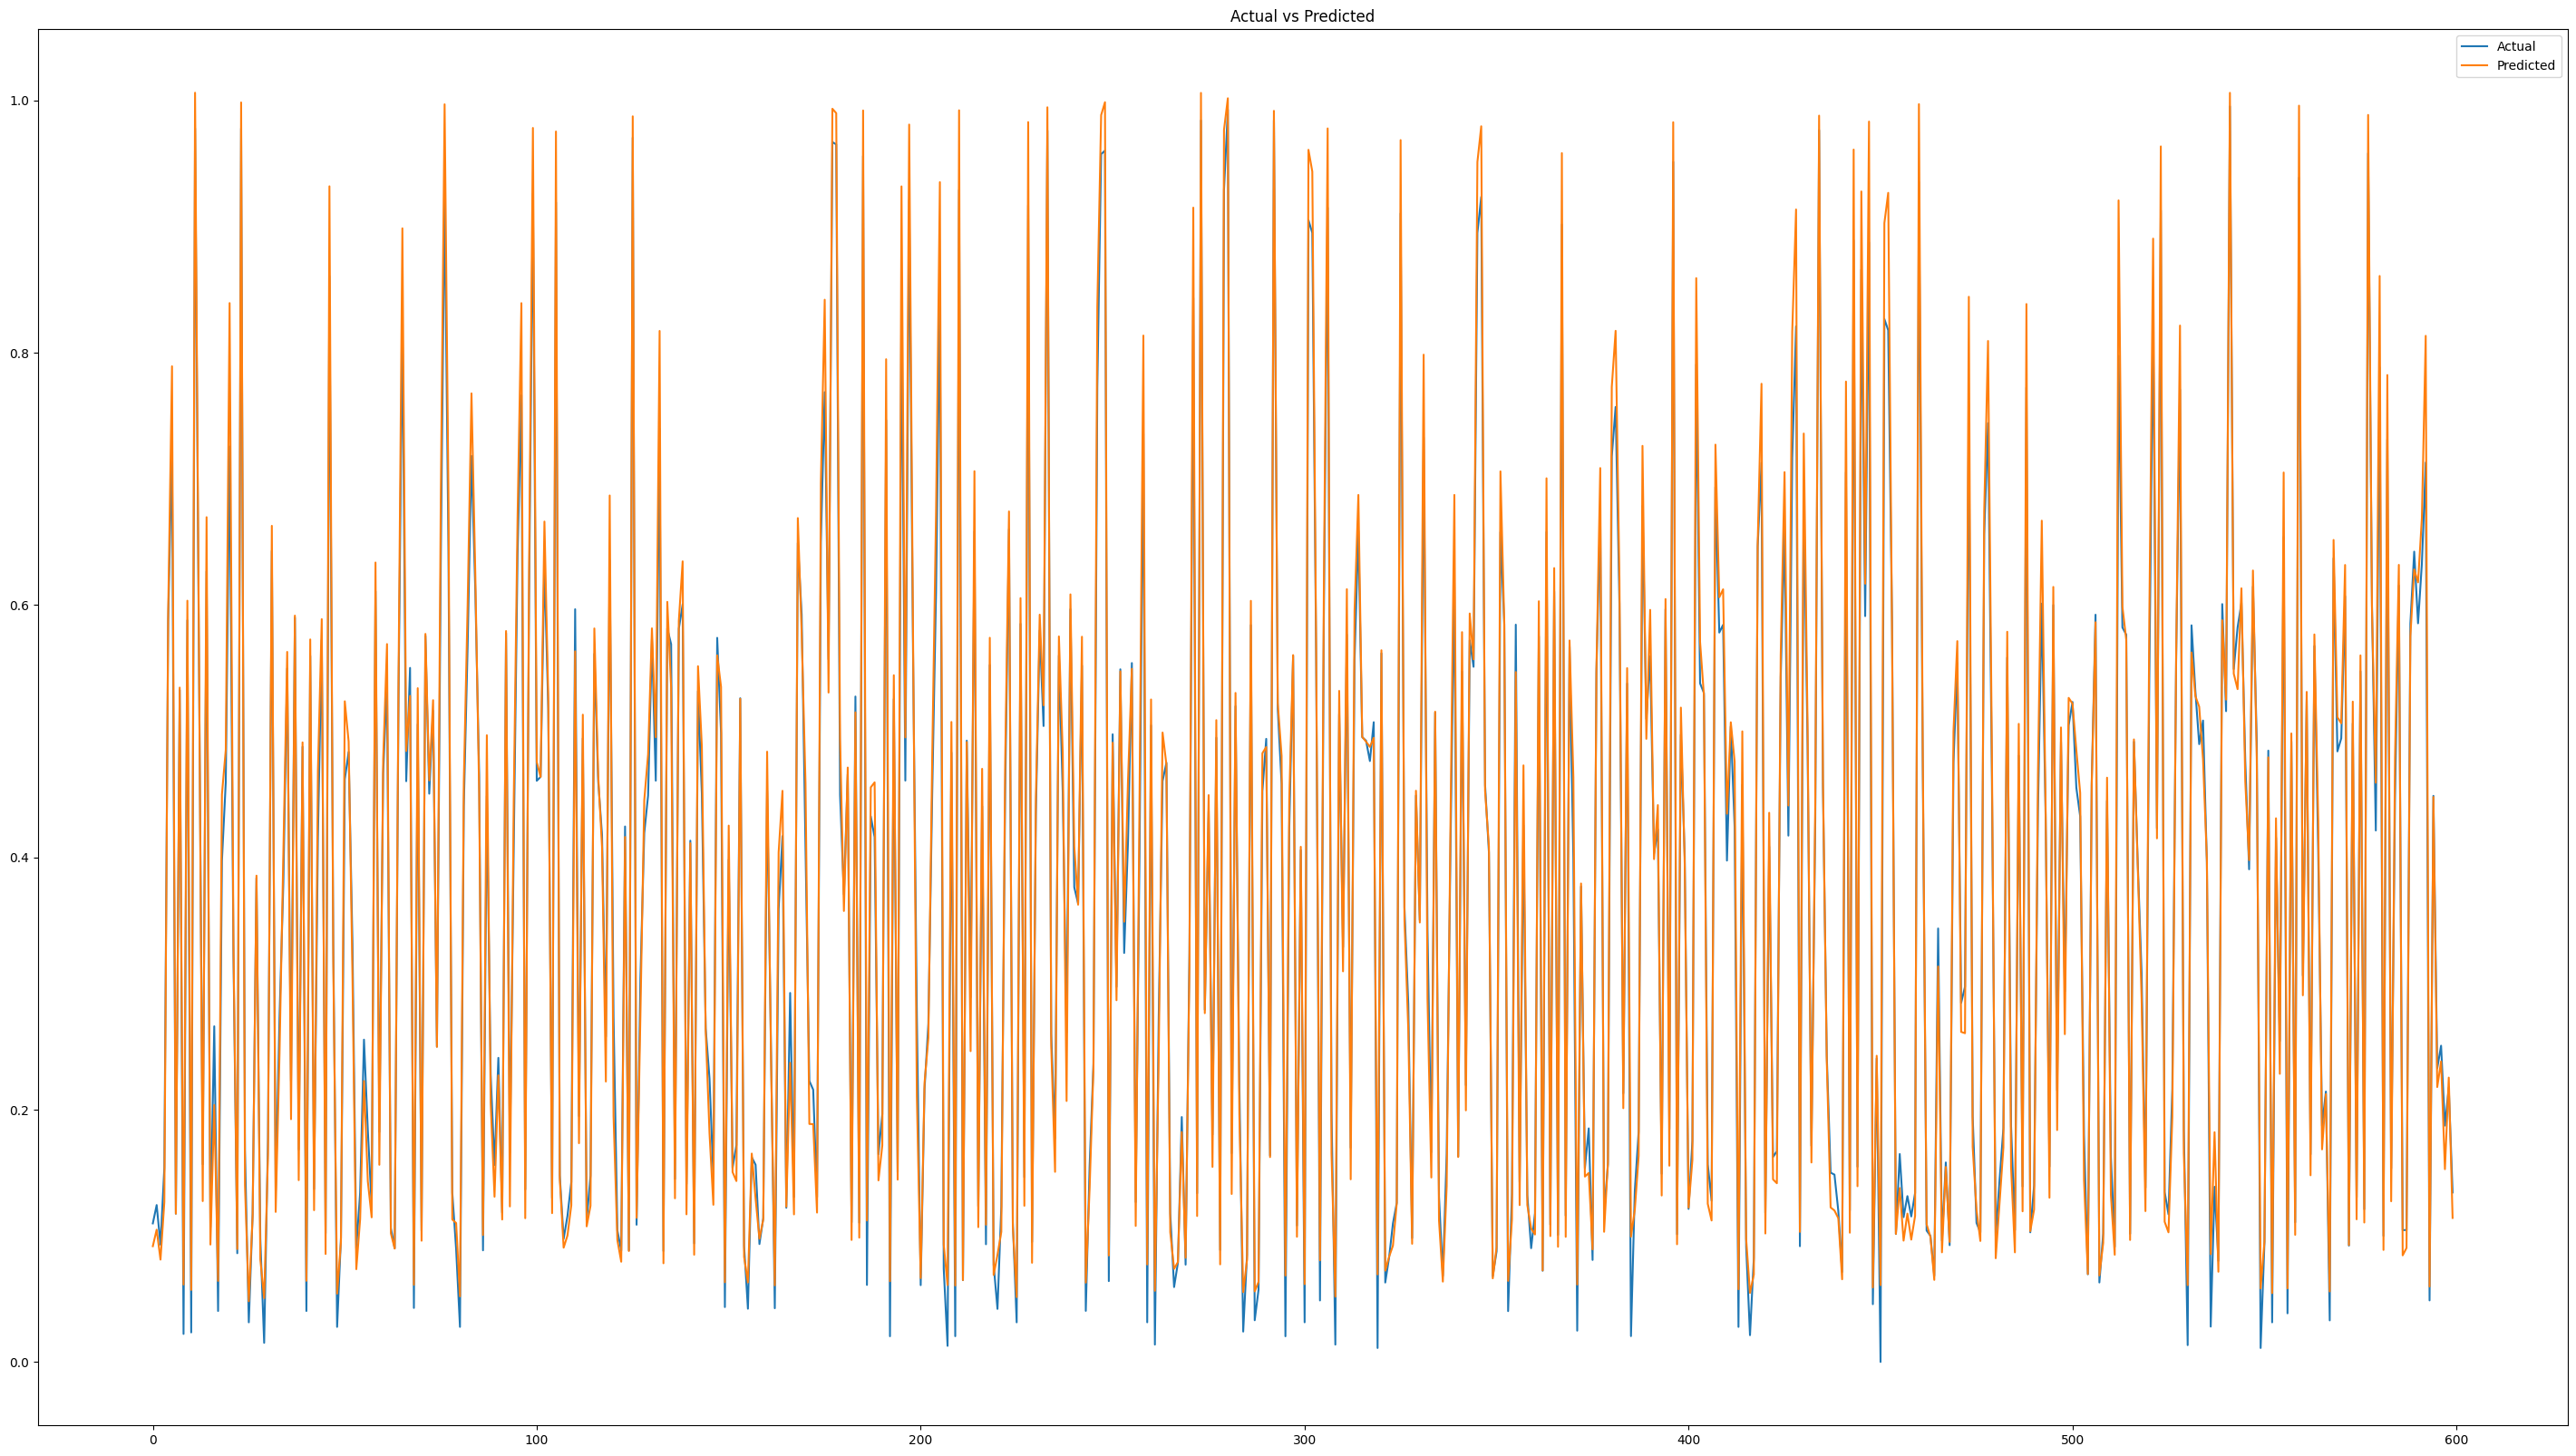

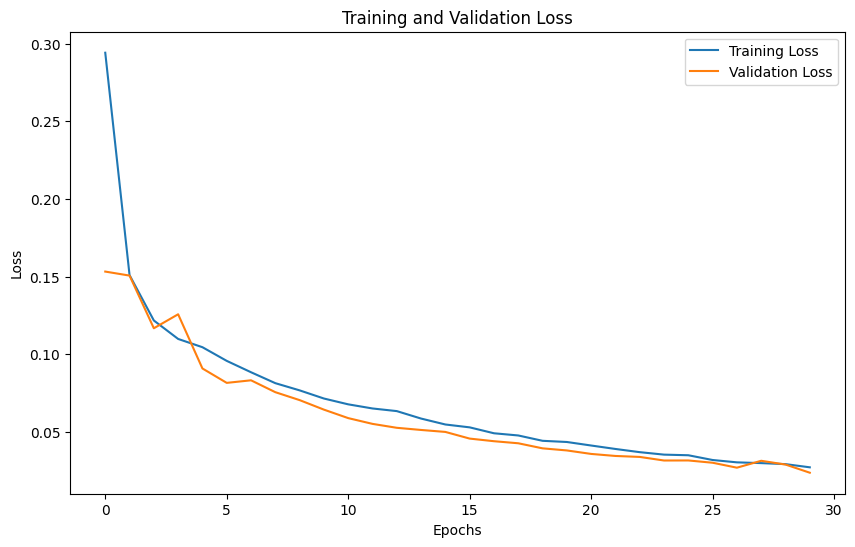

In [16]:
# 시각화
plt.figure(figsize=(36, 20))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### 4.2 LSTM

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - loss: 0.1142 - val_loss: 0.0717
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0691 - val_loss: 0.0561
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0536 - val_loss: 0.0434
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0413 - val_loss: 0.0331
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0314 - val_loss: 0.0253
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0242 - val_loss: 0.0204
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0191 - val_loss: 0.0159
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0151 - val_loss: 0.0128
Epoch 9/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0119 - val_loss: 0.0094
Epoch 10/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0097 - val_loss: 0.0073
Epoch 11/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 12/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.

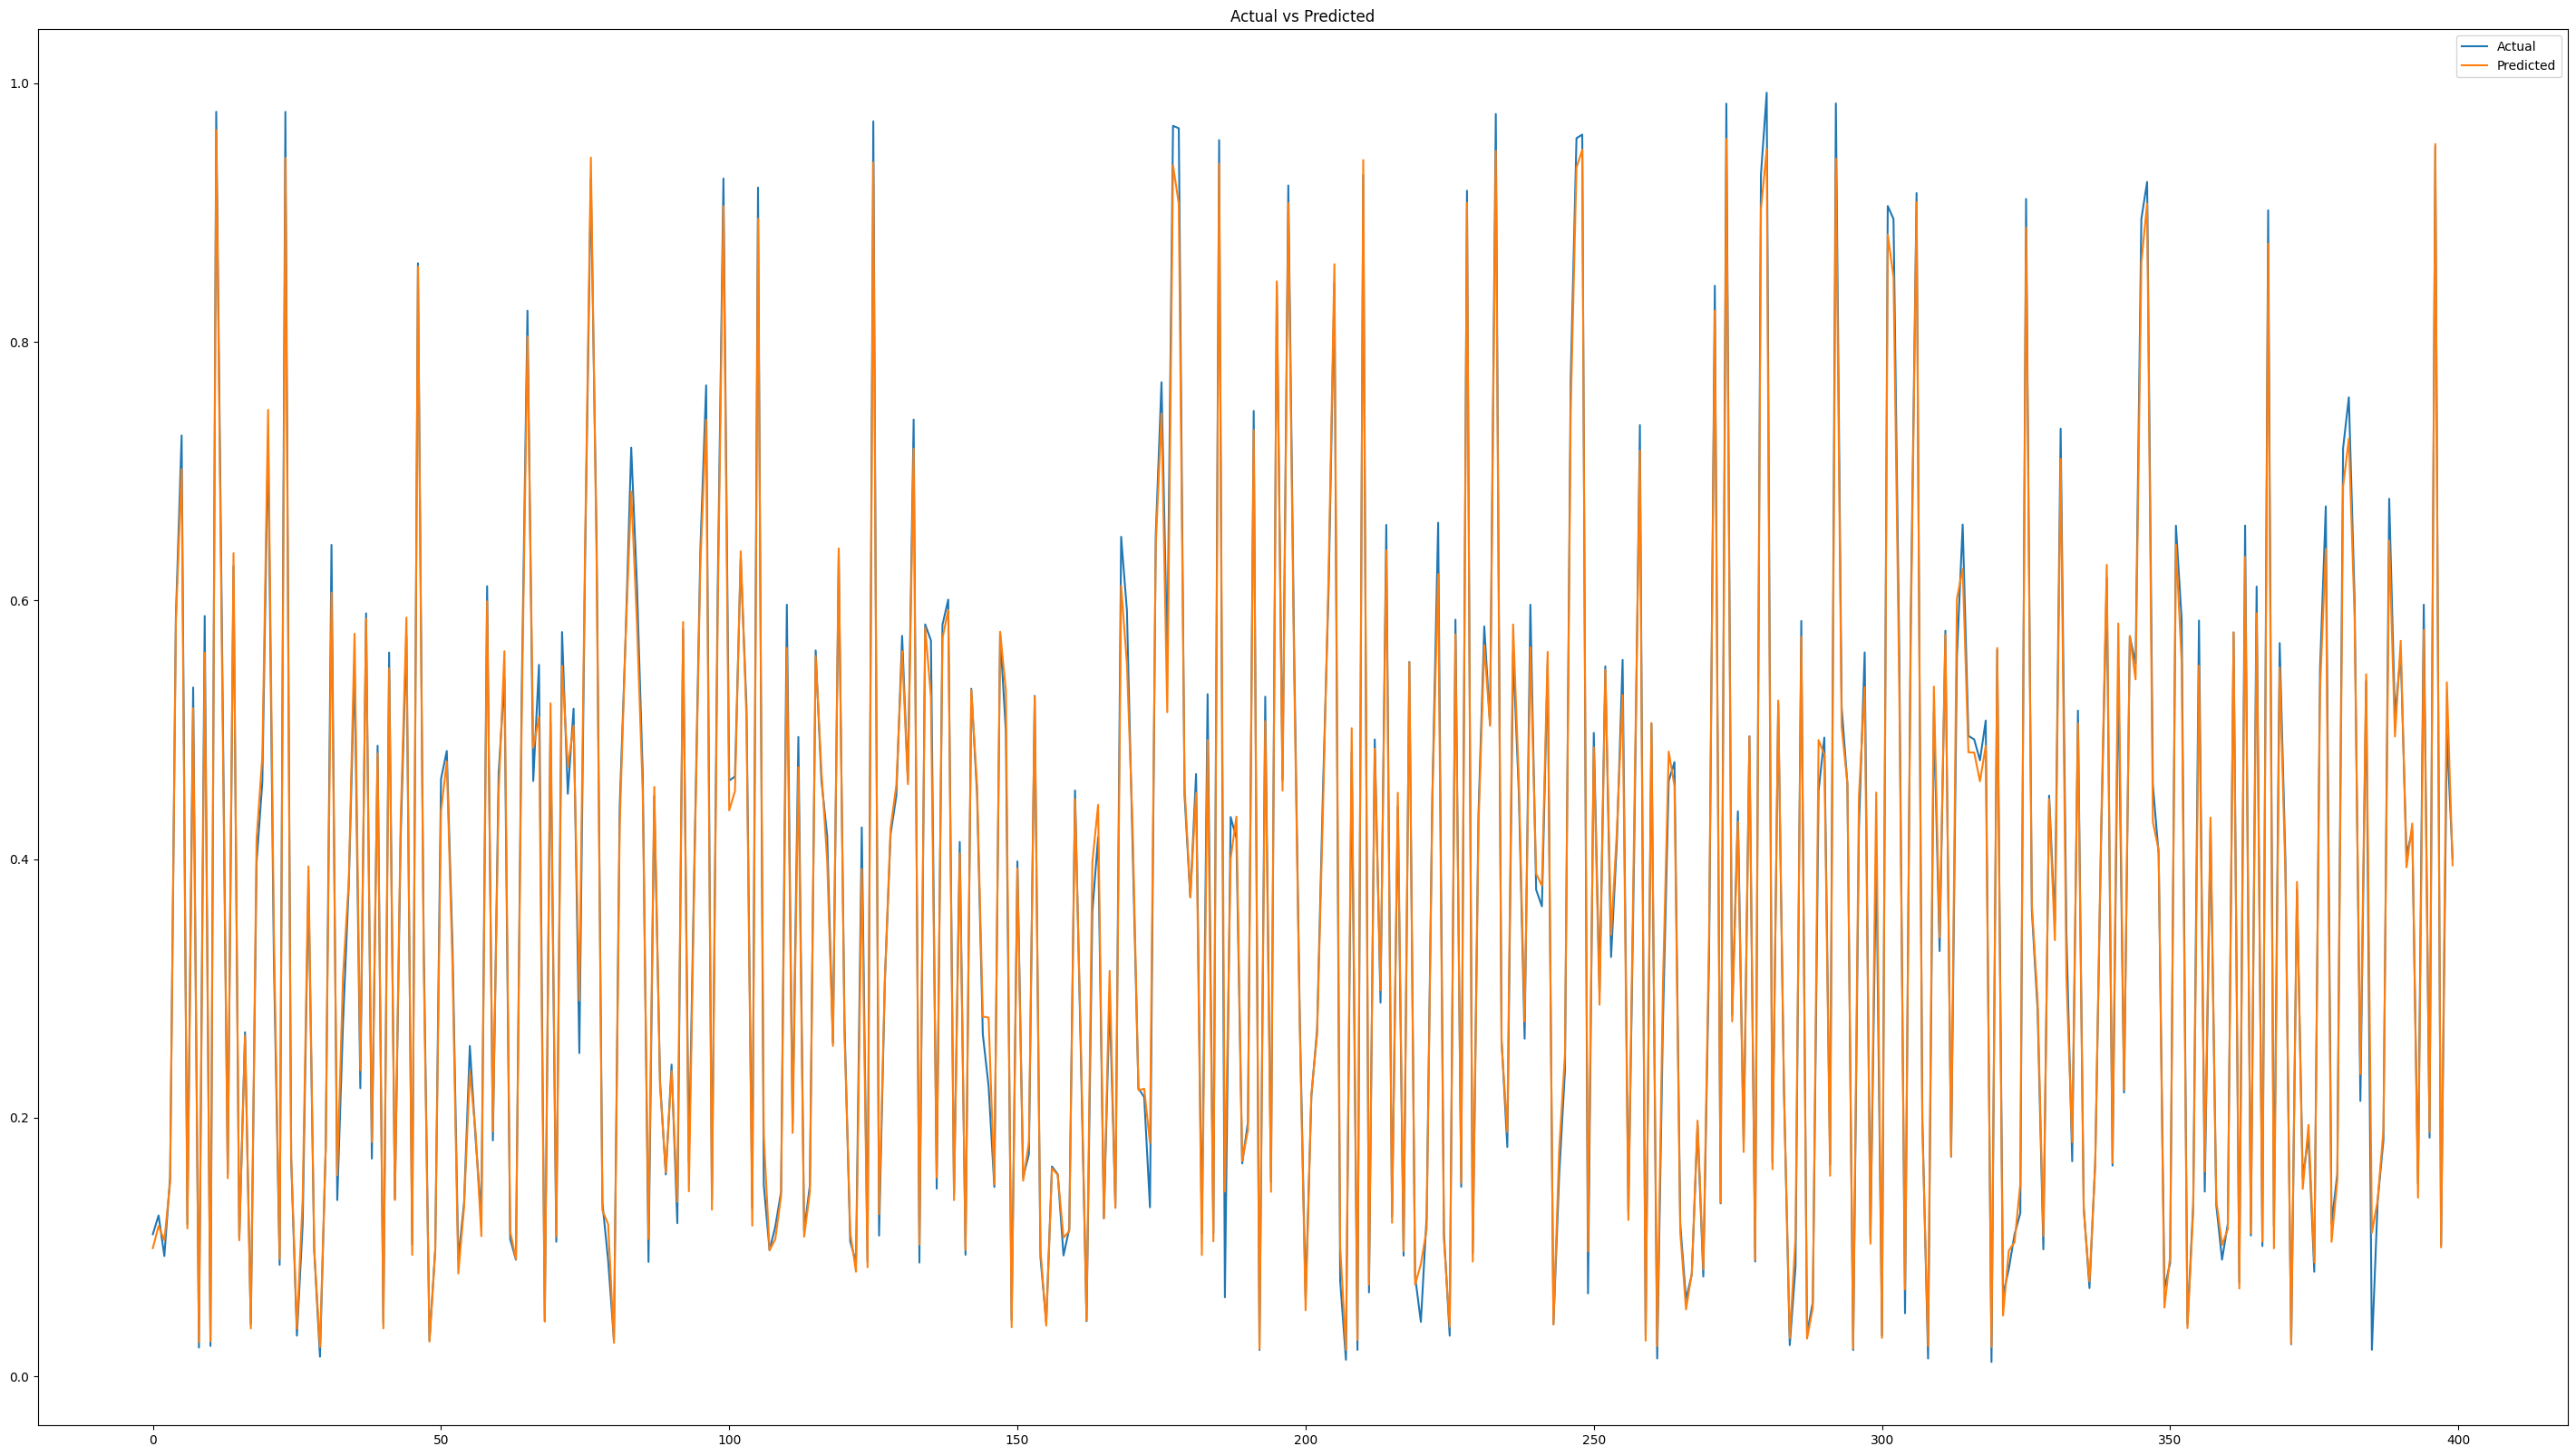

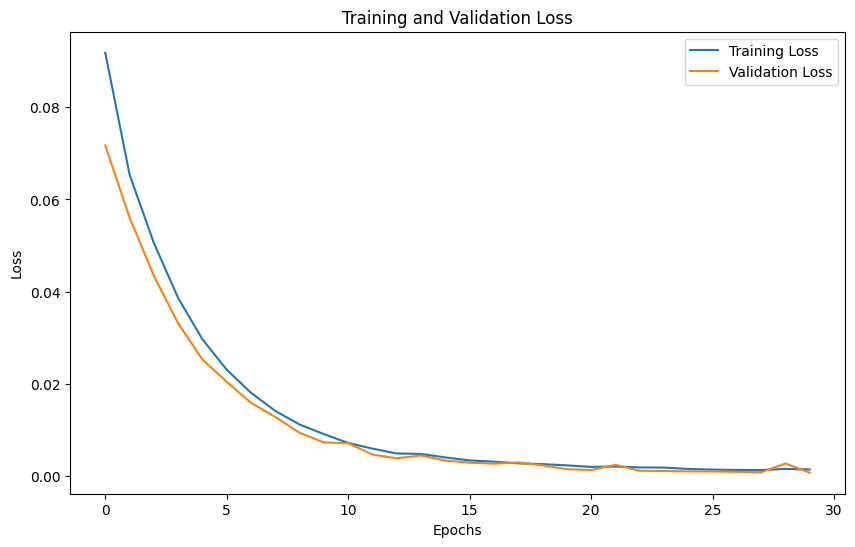

In [17]:
# 시퀀스별로 Min-Max 정규화
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler.fit_transform(y)
from tensorflow.keras import regularizers


# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 초기화 함수 정의
initializer = GlorotNormal()

# 모델 구성
model2 = Sequential()
model2.add(LSTM(128, input_shape=(SEQ_SIZE, X_train.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.002)))
model2.add(Dense(1))
optimizer = Adam(learning_rate=0.001)

model2.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model2.fit(X_train, y_train, epochs=EPOCH, validation_split=0.2, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# 모델 평가
loss = model2.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model2.predict(X_test)

# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

# 시각화
plt.figure(figsize=(36, 20))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

MSE 값을 비교한 결과, LSTM의 성능이 더 좋은 것으로 보임.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


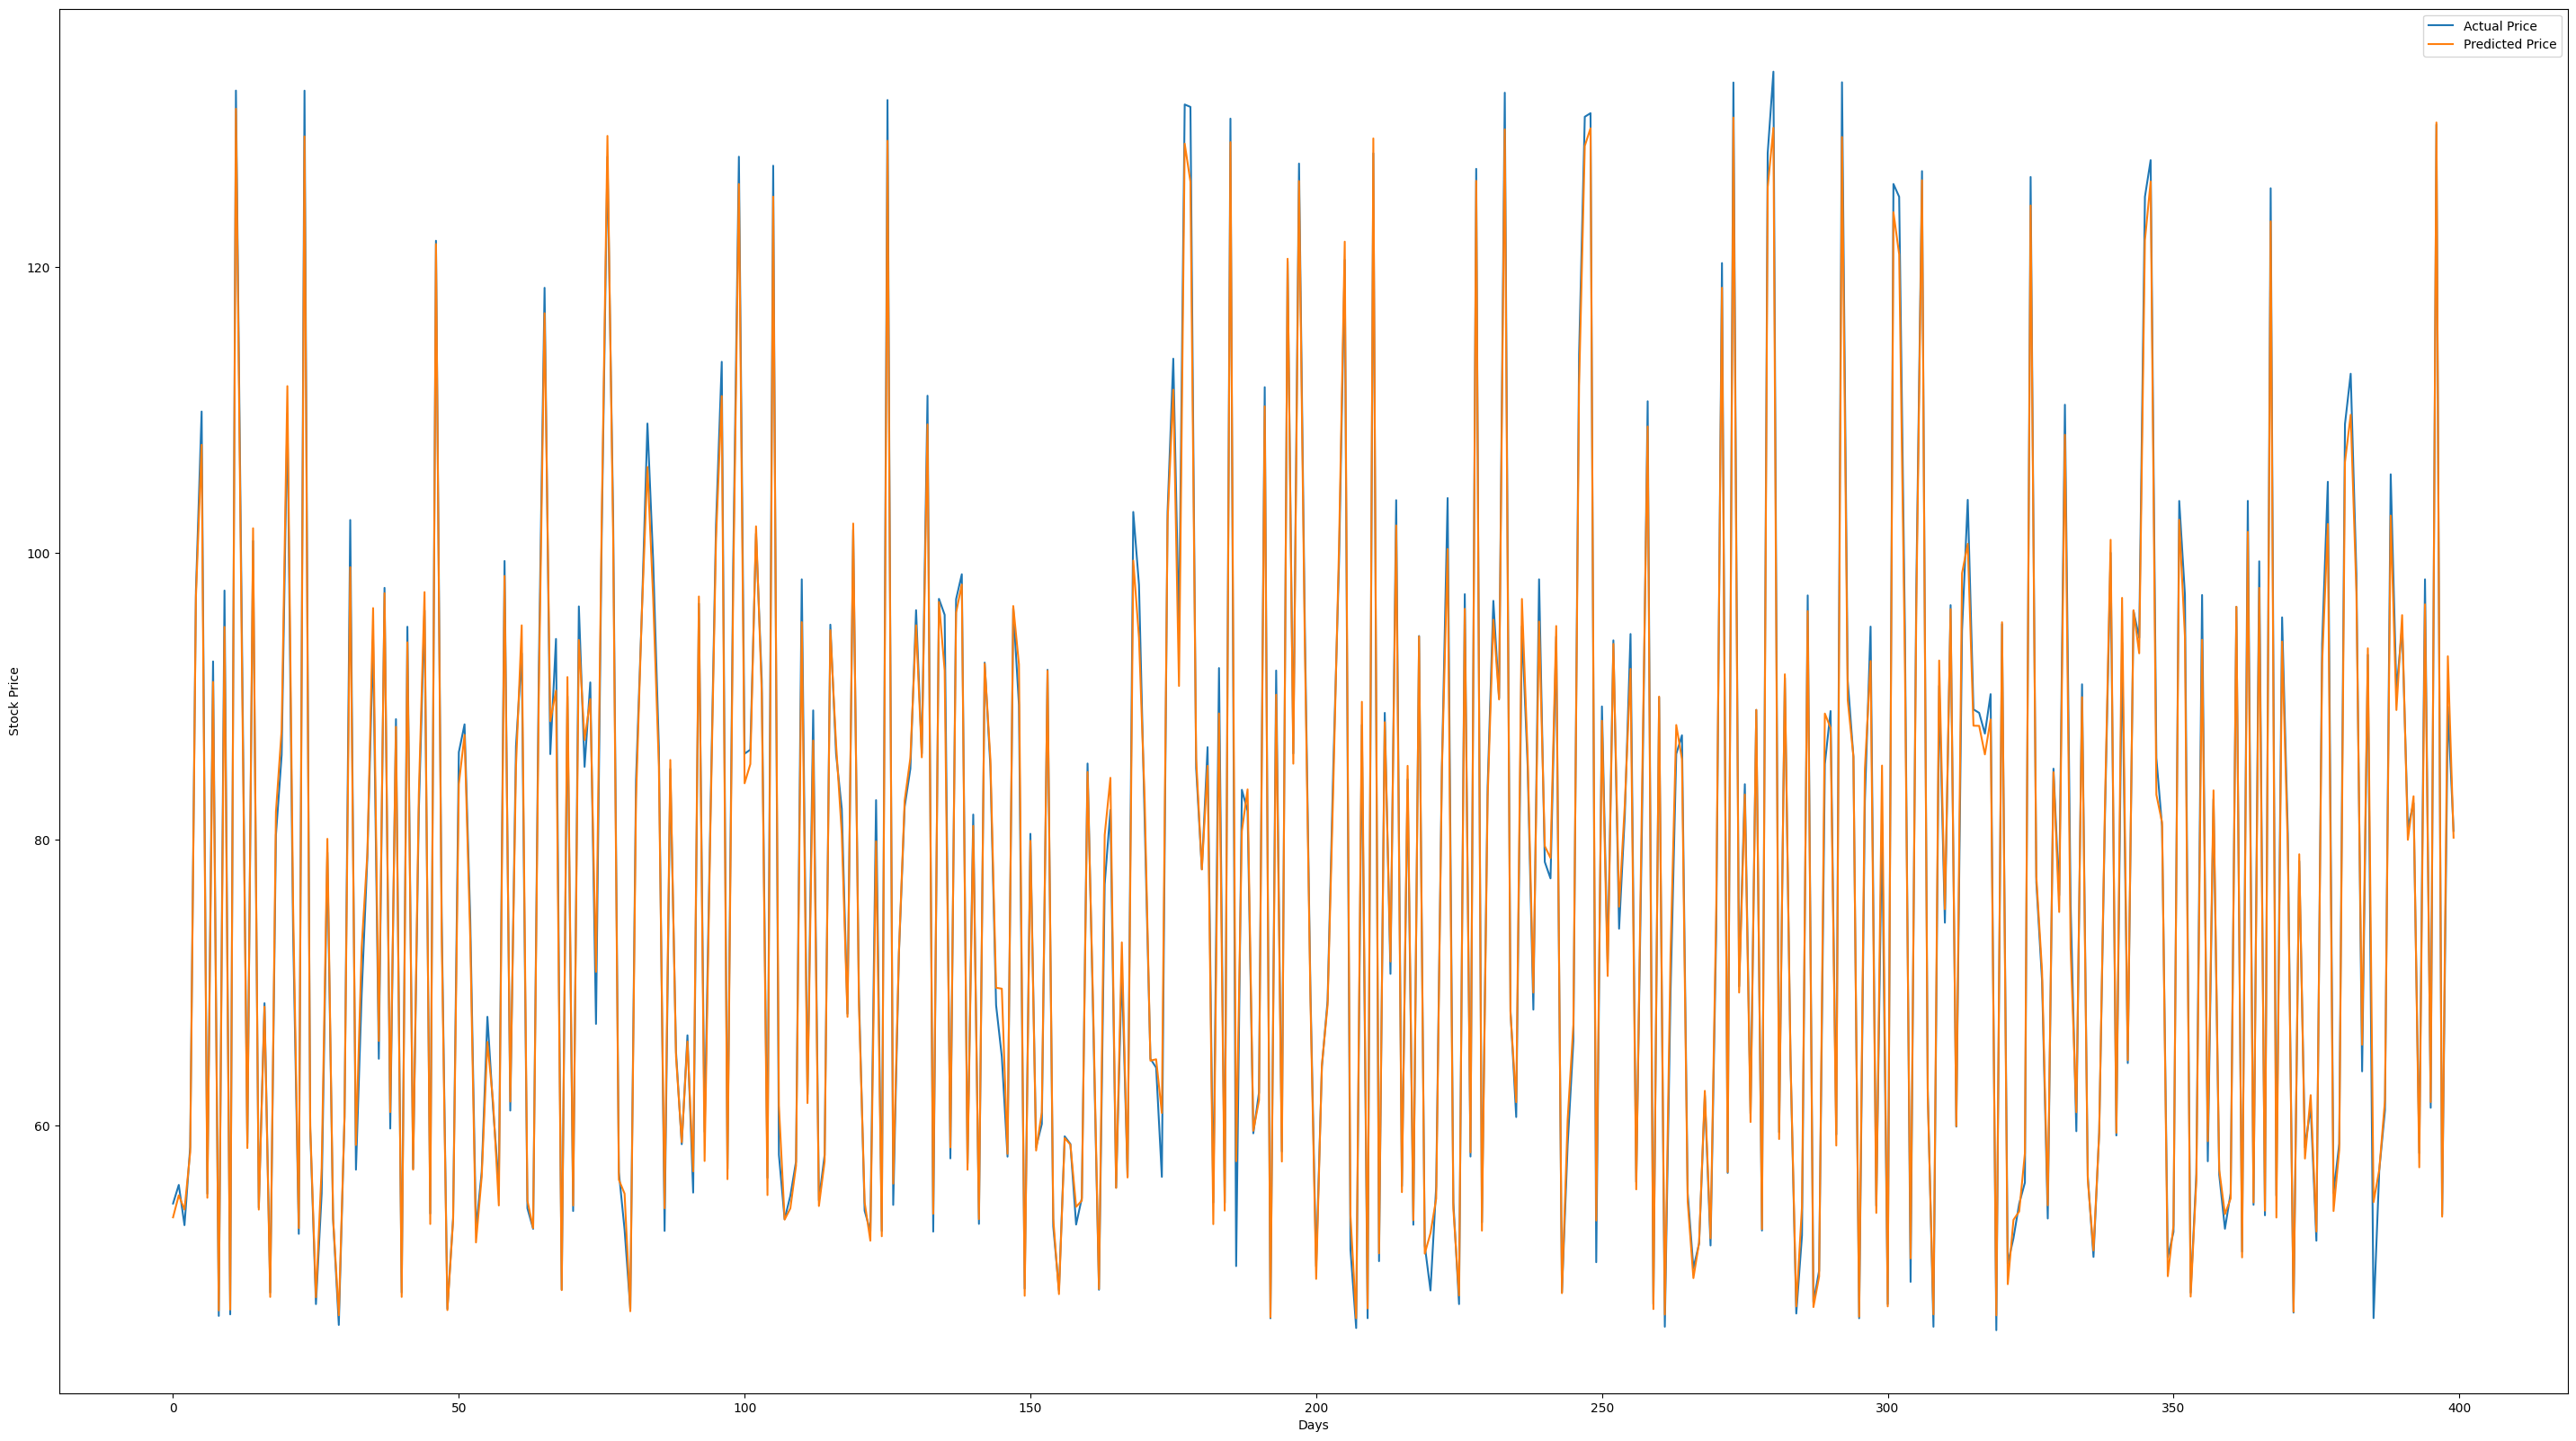

In [20]:
# 테스트 데이터 예측
predicted_price = model2.predict(X_test)

# 원래 스케일로 변환
predicted_price = scaler.inverse_transform(predicted_price.reshape(-1, 1))
real_price = scaler.inverse_transform(y_test.reshape(-1, 1))

# 예측 결과 시각화
plt.figure(figsize=(36,20))
plt.plot(real_price, label='Actual Price')
plt.plot(predicted_price, label='Predicted Price')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [24]:
# 가장 최근 50일 데이터를 가져와 예측
recent_data = y_scaled[-SEQ_SIZE:]
recent_data = np.reshape(recent_data, (1, SEQ_SIZE, 1))

# 미래 주가 예측
future_price = model2.predict(recent_data)

# 원래 가격으로 변환
future_price = scaler.inverse_transform(future_price)
print(f"예측된 미래 주가: {future_price[0][0]}")


InvalidArgumentError: Graph execution error:

Detected at node sequential_1_1/lstm_1/while/body/_1/sequential_1_1/lstm_1/while/lstm_cell_1/MatMul defined at (most recent call last):
<stack traces unavailable>
Matrix size-incompatible: In[0]: [1,1], In[1]: [14,512]
	 [[{{node sequential_1_1/lstm_1/while/body/_1/sequential_1_1/lstm_1/while/lstm_cell_1/MatMul}}]] [Op:__inference_one_step_on_data_distributed_40113]

In [22]:
esgu

,Close,Open,High,Low,Volume,Sentiment_Score,5MA,5Disparity,20MA,20Disparity,60MA,60Disparity,120MA,120Disparity
Date,,,,,,,,,,,,,,
2016-12-06,42.745953,42.745953,42.745953,42.745953,100,0.000000,42.745953,1.000000,43.538423,0.999416,44.197232,1.037707,45.228451,1.044018
2016-12-07,42.745953,42.745953,42.745953,42.745953,0,0.995544,42.745953,1.000000,43.538423,0.999416,44.197232,1.037707,45.228451,1.044018
2016-12-08,42.745953,42.745953,42.745953,42.745953,0,-0.992115,42.745953,1.000000,43.538423,0.999416,44.197232,1.037707,45.228451,1.044018
2016-12-09,42.745953,42.745953,42.745953,42.745953,0,-0.720789,42.745953,1.000000,43.538423,0.999416,44.197232,1.037707,45.228451,1.044018
2016-12-12,42.745953,42.745953,42.745953,42.745953,0,0.000000,42.745953,1.000000,43.538423,0.999416,44.197232,1.037707,45.228451,1.044018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-27,131.729996,131.940002,130.750000,130.750000,544300,0.000000,133.288001,0.988311,130.646501,1.008293,130.544483,1.009081,126.686021,1.039815
2025-01-28,132.940002,133.179993,131.389999,132.149994,609400,0.000000,133.296002,0.997329,130.685001,1.017255,130.639810,1.017607,126.854608,1.047971
2025-01-29,132.320007,132.880005,131.800003,132.679993,796800,0.000000,133.034003,0.994633,130.764001,1.011899,130.730952,1.012155,127.008342,1.041821


In [23]:
esgu[-50:]

,Close,Open,High,Low,Volume,Sentiment_Score,5MA,5Disparity,20MA,20Disparity,60MA,60Disparity,120MA,120Disparity
Date,,,,,,,,,,,,,,
2024-11-18,129.034790,129.333877,128.461549,128.566239,571000,0.0,129.987878,0.992668,128.068257,1.007547,125.340672,1.029473,121.981338,1.057824
2024-11-19,129.483429,129.603058,128.107638,128.127581,465500,0.0,129.680820,0.998478,128.169448,1.010252,125.460287,1.032067,122.113299,1.060355
2024-11-20,129.583115,129.613022,128.302050,129.523300,411800,0.0,129.383728,1.001541,128.330455,1.009761,125.579245,1.031883,122.239154,1.060079
2024-11-21,130.490341,130.788424,129.119540,130.121476,699300,0.0,129.419617,1.008273,128.520373,1.015328,125.724749,1.037905,122.371413,1.066347
2024-11-22,130.829300,130.938965,130.375687,130.490342,1546700,0.0,129.884195,1.007277,128.727738,1.016326,125.874743,1.039361,122.506084,1.067941
2024-11-25,131.347717,132.015670,130.839280,131.596954,713400,0.0,130.346780,1.007679,128.941085,1.018665,126.013673,1.042329,122.633348,1.071060
2024-11-26,131.955856,132.095428,131.427476,131.527161,631000,0.0,130.841266,1.008519,129.177860,1.021505,126.204796,1.045569,122.766010,1.074857
2024-11-27,131.437439,131.925948,131.108445,131.766433,709900,0.0,131.212131,1.001717,129.407158,1.015689,126.394233,1.039901,122.895178,1.069509
2024-11-29,132.314743,132.474258,131.626847,131.626847,468400,0.0,131.577011,1.005607,129.811420,1.019284,126.602928,1.045116,123.028601,1.075480
